# Review Text Content Models

This notebook uses the cleaned and processed text data to perform binary classification using supervised machine learning models. 

* Section 1 - Import libraries and dataset
* Section 2 - Feature Presence Vector (One-hot encoding)
* Section 3 - Feature Presence Vector Bigram
* Section 4 - BOW unigram vector
* Section 5 - BOW bigram vector
* Section 6 - TFIDF unigram vector
* Section 7 - TFIDF bigram vector
* Section 8 - Classification models training accuracy
* Section 9 - Predict on validation set
* Section 10 - Summary of results
* Section 11 - Hyperparameter tuning
* Section 12 - Grid search cv

Datasets needed to run notebook:

* cleanedsampletext.csv

Models saved to:

* TextSentimentModels.csv

# Section 1: Import libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split, KFold,cross_val_score,learning_curve,validation_curve,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve,auc,roc_auc_score,precision_recall_curve,plot_precision_recall_curve,f1_score,fbeta_score,f1_score,precision_score,recall_score
import scipy.sparse

In [3]:
df = pd.read_csv('cleanedsampletext.csv',index_col = 0)

In [4]:
df.head(2)

,OrgInd,Town,Category,Score,Review,Review_clean,Pos
0,0,Arundel,Food,1,Very disappointing Three of us ate on a quiet ...,disappointing three u ate quiet night first go...,"[('disappointing', 'JJ'), ('three', 'CD'), ('u..."
1,1,Bognor,Accommodation,0,Amazing place!!! We had a lovely stay at the ...,amazing place lovely stay inklenook room world...,"[('amazing', 'JJ'), ('place', 'NN'), ('lovely'..."


In [5]:
df.shape

(2602, 7)

In [6]:
X = df["Review_clean"]
y = df["Score"]

# Section 2: Data processing

In [7]:
# Split into training and test set as before
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
# It is noted that the train and test sets will not be exactly the same as for the Post Review Models due to the need to process
# each dataframe differently but is unlikely to make a large difference to the results.

def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=42)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [8]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X,y)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2081,) (2081,) (261,) (261,) (260,) (260,)


In [9]:
# Values of Scores - check balanced
y_train.value_counts()

1    1041
0    1040
Name: Score, dtype: int64

In [10]:
X_train.head()

665     lunch review husband eaten touchdowns pub many...
530     really poor quality bought takeaway favourite ...
731     patronising poor customer service girlfriend v...
2339    gluten free heaven wonderful little pub near b...
2281    rubbish staff took ordered waited nearly half ...
Name: Review_clean, dtype: object

# Section 2: Feature Presence (One-Hot Encoding)

### Toy Dataset example

In [315]:
# Toy dataset example of vectorizer
example = ['This restaurant is the best of the best','Love this restaurant']

In [316]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english",binary = True)
example_vec_fp = vectorizer.fit_transform(example)

In [317]:
# Examine all the words
vectorizer.get_feature_names()

['best', 'love', 'restaurant']

In [318]:
vectorizer.vocabulary_

{'restaurant': 2, 'best': 0, 'love': 1}

In [319]:
example_vec_fp.toarray()[0:3]

array([[1, 0, 1],
       [0, 1, 1]], dtype=int64)

### Full Dataset

In [320]:
# Apply to training dataset and valuation dataset - not binary set to true for one hot encoded feature presence vector
vectorizer1 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True)
vectorizer1.fit(X_train)

# Transform the training and test set to vectors
X_train_fp = vectorizer1.transform(X_train)
X_val_fp = vectorizer1.transform(X_val)

In [321]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp.shape, X_val_fp.shape)

(2081, 8403) (261, 8403)


In [322]:
# Sample vectors
X_train_fp.toarray()[0:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [323]:
feature_names = vectorizer1.get_feature_names()
dense = X_train_fp.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00fish,02,05,07,08,09,10,11,12,...,yum,yummy,zealand,zebra,zero,zing,zip,zizi,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
type(X_train_fp)

scipy.sparse.csr.csr_matrix

# Section 3: Feature Presence Bigram Model

### Toy Dataset

In [325]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words = "english",binary = True, ngram_range=(1, 2))
example_vec_fp_big = vectorizer.fit_transform(example)

In [326]:
# Examine all the words
print(vectorizer.get_feature_names())

['best', 'best best', 'love', 'love restaurant', 'restaurant', 'restaurant best']


In [327]:
vectorizer.get_feature_names()

['best',
 'best best',
 'love',
 'love restaurant',
 'restaurant',
 'restaurant best']

In [328]:
vectorizer.vocabulary_

{'restaurant': 4,
 'best': 0,
 'restaurant best': 5,
 'best best': 1,
 'love': 2,
 'love restaurant': 3}

In [329]:
example_vec_fp_big.toarray()[0:3]

array([[1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0]], dtype=int64)

### Full Dataset

In [330]:
# Apply to training dataset and valuation dataset
vectorizer2 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True, ngram_range=(1, 2))
vectorizer2.fit(X_train)

# Transform the training and test set to vectors
X_train_fp_big = vectorizer2.transform(X_train)
X_val_fp_big = vectorizer2.transform(X_val)

In [331]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp_big.shape, X_val_fp_big.shape)

(2081, 78688) (261, 78688)


In [506]:
# Uncomment to show vocabulary
vocabulary_fp_big = vectorizer2.vocabulary_
#vocabulary_fp_big

In [508]:
# Uncomment to show words sorted by frequency
word_count_fp_big = X_train_fp_big.toarray().sum(axis = 0)
sorted_words_fp_big = sorted([(word_count_fp_big[i],wd)for wd,i in vocabulary_fp_big.items()],reverse=True)
#sorted_words_fp_big

In [334]:
# Sample vectors
X_train_fp_big.toarray()[0:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Section 4: Count Frequency Model

### Toy Dataset example

In [335]:
# Instantiate count vectorizer object and fit and transform on the example dataset. 
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
example_vec = vectorizer3.fit_transform(example)

In [336]:
# Examine all the words
vectorizer3.get_feature_names()

['best', 'love', 'restaurant']

In [337]:
# Print the full vocabulary of all words
print(vectorizer3.vocabulary_)

{'restaurant': 2, 'best': 0, 'love': 1}


In [338]:
# Show first sentence as a vector
example_vec.toarray()[0:3]

array([[2, 0, 1],
       [0, 1, 1]], dtype=int64)

## Full dataset

In [339]:
# Apply to training dataset and valuation dataset
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
vectorizer3.fit(X_train)

# Transform the training and test set to vectors
X_train_bow = vectorizer3.transform(X_train)
X_val_bow = vectorizer3.transform(X_val)

In [340]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bow.shape, X_val_bow.shape, y_train.shape, y_val.shape)

(2081, 8403) (261, 8403) (2081,) (261,)


In [341]:
# The matrix is a sparse matrix made up of mostly zeros
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [342]:
# Look at one example
X_train_bow[10].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [343]:
# Looking at the example above the dense array has 37 words
X_train_bow[10]

<1x8403 sparse matrix of type '<class 'numpy.int64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [344]:
# Get a range of words from the vocabulary
print(vectorizer3.get_feature_names()[2000:2050])

['dee', 'deem', 'deemed', 'deep', 'deer', 'def', 'defeater', 'defence', 'defend', 'defensive', 'deffo', 'defiantly', 'deficit', 'definately', 'definatly', 'define', 'definetly', 'definite', 'definitely', 'deflated', 'defo', 'defrosted', 'defrostedcomplainedtold', 'degenerated', 'degree', 'delay', 'delayed', 'deleted', 'deleting', 'deliberately', 'delicacy', 'delicious', 'deliciously', 'delight', 'delighted', 'delightful', 'delightfully', 'delirious', 'delish', 'deliver', 'delivered', 'delivers', 'delivery', 'delorean', 'delusion', 'deluxe', 'demand', 'demanded', 'demographic', 'demolished']


In [509]:
# Show each word with a unique ID identifier - Uncomment to show
vocabulary_bow = vectorizer3.vocabulary_
#vocabulary_bow.items()

In [346]:
len(vocabulary_bow)

8403

In [510]:
# Most highly occurring words in the vocabulary - Uncomment to show
word_count_bow = X_train_bow.toarray().sum(axis = 0)
sorted_words_bow = sorted([(word_count_bow[i],wd)for wd,i in vocabulary_bow.items()],reverse=True)
#sorted_words_bow

In [348]:
feature_names = vectorizer3.get_feature_names()
dense = X_train_bow.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00fish,02,05,07,08,09,10,11,12,...,yum,yummy,zealand,zebra,zero,zing,zip,zizi,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Section 5: Countvectorizer Bigram Model

## Toy dataset

In [349]:
# Set up bigram model with example text
vectorizer4 = CountVectorizer(analyzer='word', max_df=1.0, min_df=1, stop_words = "english",ngram_range=(1, 2))
example_bow = vectorizer4.fit_transform(example)
print(vectorizer4.vocabulary_)

{'restaurant': 4, 'best': 0, 'restaurant best': 5, 'best best': 1, 'love': 2, 'love restaurant': 3}


In [350]:
# Show the three vectors for the sample sentences
print(example_bow.toarray())

[[2 1 0 0 1 1]
 [0 0 1 1 1 0]]


In [351]:
# The vocabulary of the example data with the unique ID
vectorizer4.vocabulary_

{'restaurant': 4,
 'best': 0,
 'restaurant best': 5,
 'best best': 1,
 'love': 2,
 'love restaurant': 3}

## Full dataset

In [352]:
# Apply to whole dataset with unigrams and bigrams. Set up ngram vectorizer and fit to training data
# words must appear in at least 2 documents and not in more than 98% of documents to limit the vocabulary size
vectorizer4 = CountVectorizer(analyzer='word', max_df=0.98, stop_words = "english",min_df=2, ngram_range=(1,2))
vectorizer4.fit(X_train)

# Transform the training and test set to vectors for use in model training and predicting
X_train_ngram = vectorizer4.transform(X_train)
X_val_ngram = vectorizer4.transform(X_val)

In [353]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix. Ten times as many
# words and ngrams in the training and test set compared to the BOW model
print(X_train_ngram.shape, X_val_ngram.shape, y_train.shape, y_val.shape)

(2081, 12720) (261, 12720) (2081,) (261,)


In [354]:
# Get vocabulary length to check
vocabulary_ngram = vectorizer4.vocabulary_
len(vocabulary_ngram)

12720

In [355]:
# Sample of all unigrams and bigrams in dictionary fitted on the training set
print(vectorizer4.get_feature_names()[10000:10050])

['shocked state', 'shocking', 'shocking experience', 'shockingly', 'shoddy', 'shoe', 'shoot', 'shop', 'shop buy', 'shop cafe', 'shop family', 'shop hotel', 'shop told', 'short', 'short acceptable', 'short break', 'short family', 'short notice', 'short staffed', 'short stay', 'short stroll', 'short wait', 'short walk', 'shortage', 'shorter', 'shortly', 'shot', 'shoulder', 'shout', 'shouted', 'shouting', 'shouting banging', 'shouting staff', 'showed', 'showed room', 'showed table', 'showed waitress', 'shower', 'shower bath', 'shower cubicle', 'shower good', 'shower head', 'shower poor', 'shower room', 'shower tray', 'shower work', 'showing', 'shown', 'shown room', 'shown table']


In [511]:
# Show each word and ngram with unique ID in the dictionary - Uncomment to show
#vocabulary_ngram.items()

In [357]:
# Print array of one item in the training set
print(X_train_ngram.toarray()[50])

[0 0 0 ... 0 0 0]


In [358]:
# Get word count for each word in the corpus
word_count = X_train_ngram.toarray().sum(axis = 0)
word_count

array([29,  2,  2, ...,  9,  2,  2], dtype=int64)

In [512]:
# Get the highest frequency ngrams with the amount of times they occur in the corpus - Uncomment to show
sorted_words = sorted([(word_count[i],ngram)for ngram,i in vocabulary_ngram.items()],reverse=True)
#sorted_words

In [360]:
feature_names = vectorizer4.get_feature_names()
dense = X_train_ngram.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00 arrived,00 delivery,00 night,05,10,10 30,11,11 30,12,...,youngest,youngster,yr,yr old,yuk,yum,yummy,zero,zero star,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Section 6 :TFIDF Vectorizer - Unigram Model

## Toy Dataset

In [361]:
# Set up TFIDF vectorizer for the toy dataset
vectorizer5 = TfidfVectorizer(use_idf = True, stop_words='english',smooth_idf = True, norm = 'l2')
example_bow = vectorizer5.fit_transform(example)

In [362]:
example_bow.toarray()[0:3]

array([[0.94, 0.  , 0.34],
       [0.  , 0.81, 0.58]])

In [363]:
vectorizer5.vocabulary_

{'restaurant': 2, 'best': 0, 'love': 1}

In [364]:
feature_names5 = vectorizer5.get_feature_names()
dense = example_bow.todense()
denselist = dense.tolist()
df_vector5 = pd.DataFrame(denselist, columns = feature_names5)
print(vectorizer5.vocabulary_)

{'restaurant': 2, 'best': 0, 'love': 1}


In [365]:
df_vector5

,best,love,restaurant
0,0.942156,0.000000,0.335176
1,0.000000,0.814802,0.579739


## Full Dataset

In [366]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer5 = TfidfVectorizer(use_idf = True, max_df = 1.0,min_df = 1, stop_words = "english",smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer5.fit(X_train)

TfidfVectorizer(stop_words='english')

In [367]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf1 = vectorizer5.transform(X_train)
X_val_tfidf1 = vectorizer5.transform(X_val)

In [368]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf1.shape, X_val_tfidf1.shape, y_train.shape, y_val.shape)

(2081, 8403) (261, 8403) (2081,) (261,)


In [513]:
# Print vocabulary and unique ID - Uncomment to show
#print(vectorizer5.vocabulary_)

In [370]:
# Sample of words in the dictionary
print(vectorizer5.get_feature_names()[300:350])

['anchovy', 'ancient', 'andalusia', 'andi', 'andjump', 'andrew', 'andthe', 'andwas', 'anemic', 'angel', 'anger', 'angering', 'angle', 'angry', 'animal', 'anisakiasis', 'anisakid', 'aniversary', 'ankle', 'anna', 'annex', 'annexe', 'anniversary', 'announce', 'announced', 'announcement', 'annoyed', 'annoying', 'annoys', 'annual', 'annually', 'anotherhotel', 'anout', 'answer', 'answerbusypoorly', 'answered', 'answering', 'answerone', 'answerphone', 'antagonistic', 'antarctica', 'anther', 'anthony', 'anti', 'antic', 'anticipate', 'anticipated', 'antipasto', 'antiquated', 'antique']


In [371]:
# Show the words and the associated weights - uncomment to show
#dict(zip(vectorizer4.get_feature_names(),vectorizer4.idf_))

In [372]:
feature_names = vectorizer5.get_feature_names()
dense = X_train_tfidf1.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00fish,02,05,07,08,09,10,11,12,...,yum,yummy,zealand,zebra,zero,zing,zip,zizi,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 7: TFIDF - BIGRAM MODEL

### Toy Dataset

In [373]:
# Set up TFIDF vectorizer for the toy dataset
vectorizer = TfidfVectorizer(use_idf = True, stop_words='english',smooth_idf = True, norm = 'l2',ngram_range=(1, 2))
example = vectorizer.fit_transform(example)

In [374]:
feature_names = vectorizer.get_feature_names()
dense = example.todense()
denselist = dense.tolist()
df_vector = pd.DataFrame(denselist, columns = feature_names)
print(vectorizer.vocabulary_)

{'restaurant': 4, 'best': 0, 'restaurant best': 5, 'best best': 1, 'love': 2, 'love restaurant': 3}


In [375]:
df_vector

,best,best best,love,love restaurant,restaurant,restaurant best
0,0.784088,0.392044,0.000000,0.000000,0.278943,0.392044
1,0.000000,0.000000,0.631667,0.631667,0.449436,0.000000


### Full Dataset

In [376]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer6 = TfidfVectorizer(use_idf = True, max_df = 0.98,min_df =2,stop_words = "english",ngram_range=(1,2),smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer6.fit(X_train)

TfidfVectorizer(max_df=0.98, min_df=2, ngram_range=(1, 2), stop_words='english')

In [377]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf2 = vectorizer6.transform(X_train)
X_val_tfidf2 = vectorizer6.transform(X_val)

In [378]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf2.shape, X_val_tfidf2.shape, y_train.shape, y_val.shape)

(2081, 12720) (261, 12720) (2081,) (261,)


In [379]:
# Sample of words in the dictionary
print(vectorizer6.get_feature_names()[500:550])

['arrived shocked', 'arrived shown', 'arrived site', 'arrived table', 'arrived told', 'arrived waiter', 'arrived wife', 'arrives', 'arriving', 'arriving room', 'arrogance', 'arrogant', 'art', 'art craft', 'artefact', 'arun', 'arun view', 'ash', 'ashamed', 'aside', 'ask', 'ask cutlery', 'ask food', 'ask gave', 'ask left', 'ask manager', 'ask menu', 'ask reception', 'ask room', 'ask staff', 'asked', 'asked booked', 'asked check', 'asked coke', 'asked drink', 'asked food', 'asked going', 'asked gravy', 'asked help', 'asked hotel', 'asked jug', 'asked leave', 'asked like', 'asked main', 'asked manager', 'asked meal', 'asked member', 'asked menu', 'asked money', 'asked moved']


In [514]:
# Show the words and the associated weights - Uncomment to show
#dict(zip(vectorizer6.get_feature_names(),vectorizer6.idf_))

In [381]:
feature_names = vectorizer6.get_feature_names()
dense = X_train_tfidf2.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,00,00 arrived,00 delivery,00 night,05,10,10 30,11,11 30,12,...,youngest,youngster,yr,yr old,yuk,yum,yummy,zero,zero star,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.09061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 8: Training Accuracy on Each of the Vectorizer Objects

In [382]:
# Set models
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True)

In [383]:
# Function to train with specified model on the training set - 5 fold as the dataset for ngrams is very large

def train_accuracy(model,X,y,vector):
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
    cv_results = cross_val_score(model, X, y, cv = kf, scoring = "accuracy", n_jobs =-1)

    train_accuracy.results = pd.DataFrame({vector:cv_results.mean()}, index = [0])
                                

## Dummy Classifier

In [384]:
# BOW
train_accuracy(dummy_model,X_train_bow,y_train,"BOW-dum")
dum_train_bow = train_accuracy.results
dum_train_bow

,BOW-dum
0,0.503113


## Naive Bayes

In [394]:
# Feature Presence
train_accuracy(nb,X_train_fp, y_train, "FP")
nb_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(nb,X_train_fp_big, y_train, "FP BIG")
nb_train_fp_big = train_accuracy.results

# BOW
train_accuracy(nb,X_train_bow,y_train,"BOW")
nb_train_bow = train_accuracy.results

# ngram
train_accuracy(nb,X_train_ngram,y_train,"BIGRAM")
nb_train_ngram = train_accuracy.results

# TFIDF unigram
train_accuracy(nb,X_train_tfidf1,y_train,"TFIDF UNI")
nb_train_tfidf1 = train_accuracy.results

# TFIDF bigram
train_accuracy(nb,X_train_tfidf2,y_train,"TFIDF BI")
nb_train_tfidf2 = train_accuracy.results

## Logistic Regression

In [390]:
# Feature Presence
train_accuracy(lr,X_train_fp, y_train, "FP")
lr_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(lr,X_train_fp_big, y_train, "FP BIG")
lr_train_fp_big = train_accuracy.results

# BOW
train_accuracy(lr,X_train_bow,y_train,"BOW")
lr_train_bow = train_accuracy.results

# ngrams
train_accuracy(lr,X_train_ngram,y_train,"BIGRAM")
lr_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(lr,X_train_tfidf1,y_train,"TFIDF UNI")
lr_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(lr,X_train_tfidf2,y_train,"TFIDF BI")
lr_train_tfidf2 = train_accuracy.results

## Random Forest

In [391]:
# Feature Presence
train_accuracy(rf,X_train_fp, y_train, "FP")
rf_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(rf,X_train_fp_big, y_train, "FP BIG")
rf_train_fp_big = train_accuracy.results

# BOW
train_accuracy(rf,X_train_bow,y_train,"BOW")
rf_train_bow = train_accuracy.results

# bigrams
train_accuracy(rf,X_train_ngram,y_train,"BIGRAM")
rf_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(rf,X_train_tfidf1,y_train,"TFIDF UNI")
rf_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(rf,X_train_tfidf2,y_train,"TFIDF BI")
rf_train_tfidf2 = train_accuracy.results

## Support Vector Machines

In [392]:
# Feature Presence
train_accuracy(svm,X_train_fp, y_train, "FP")
svm_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(svm,X_train_fp_big, y_train, "FP BIG")
svm_train_fp_big = train_accuracy.results

# BOW
train_accuracy(svm,X_train_bow,y_train,"BOW")
svm_train_bow = train_accuracy.results

# bigrams
train_accuracy(svm,X_train_ngram,y_train,"BIGRAM")
svm_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(svm,X_train_tfidf1,y_train,"TFIDF UNI")
svm_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(svm,X_train_tfidf2,y_train,"TFIDF BI")
svm_train_tfidf2 = train_accuracy.results

In [395]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]
fp = pd.concat([nb_train_fp, lr_train_fp, rf_train_fp, svm_train_fp])
fp_big = pd.concat([nb_train_fp_big, lr_train_fp_big, rf_train_fp_big, svm_train_fp_big])
bow = pd.concat([nb_train_bow,lr_train_bow,rf_train_bow,svm_train_bow])
big = pd.concat([nb_train_ngram,lr_train_ngram,rf_train_ngram,svm_train_ngram])
tfidf = pd.concat([nb_train_tfidf1,lr_train_tfidf1,rf_train_tfidf1,svm_train_tfidf1])
tfidf_big = pd.concat([nb_train_tfidf2,lr_train_tfidf2,rf_train_tfidf2,svm_train_tfidf2])

In [396]:
all_models = pd.concat([fp,fp_big,bow,big,tfidf,tfidf_big],axis = 1)
all_models.set_index([models],inplace = True)
all_models

,FP,FP BIG,BOW,BIGRAM,TFIDF UNI,TFIDF BI
Multinomial NB,0.945697,0.948578,0.947617,0.954348,0.950023,0.950499
Logistic Regression,0.944737,0.942334,0.937522,0.943771,0.944253,0.946653
Random Forest,0.924066,0.905802,0.922622,0.922624,0.917818,0.918780
Support Vector Machine,0.923588,0.906761,0.917338,0.917334,0.946179,0.948576


The multinomial NB Bigram model has the highest training accuracy

# Section 9: Prediction on validation set with each of the Models

In [397]:
# Diagnostic and Graphing Function from previous modelling

def run_mod(model,X_train,y_train,X_val,y_val):
        
    
    # Fit model on training set and predict on test set
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
                    
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, test_scores = learning_curve(model,X_train,y_train, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.mean(test_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.title("Precision Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive class
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Test Set Metrics
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)

## Feature Presence

### Naive Bayes

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       131
           1       0.94      0.97      0.95       130

    accuracy                           0.95       261
   macro avg       0.95      0.95      0.95       261
weighted avg       0.95      0.95      0.95       261



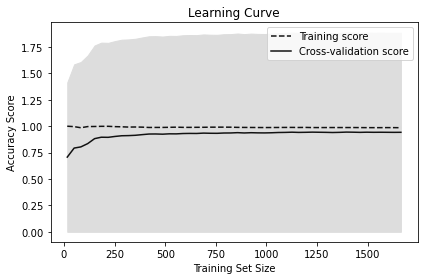

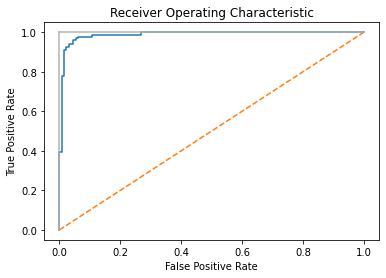

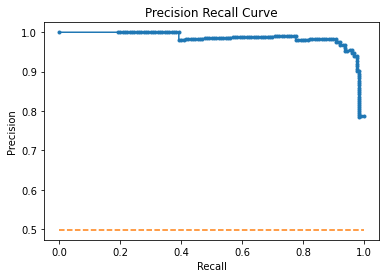

Best F1 score: 0.9545454545454547 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.954023,0.940299,0.969231,0.954545,0.963303,0.987375,0.985619


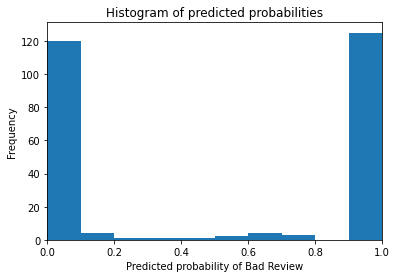

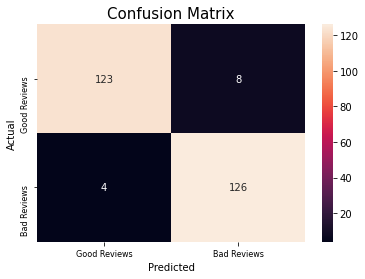

In [398]:
run_mod(nb,X_train_fp,y_train,X_val_fp,y_val)
nb_results1 = run_mod.results
nb_results1

### Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       131
           1       0.95      0.93      0.94       130

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261



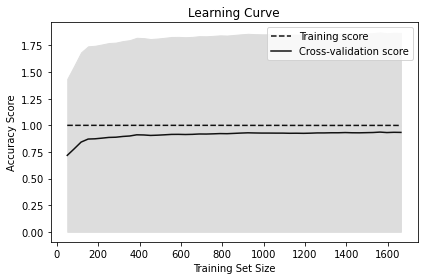

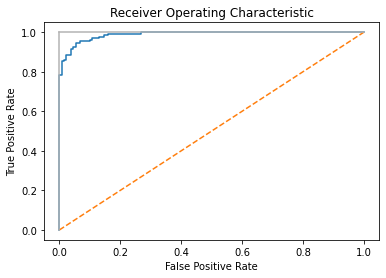

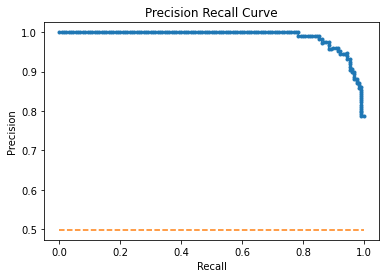

Best F1 score: 0.937984496124031 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.938697,0.945312,0.930769,0.937984,0.933642,0.98855,0.989092


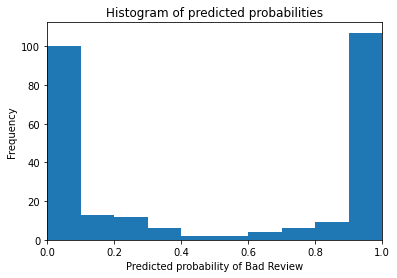

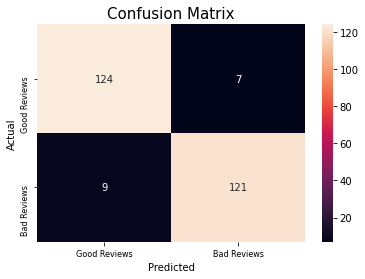

In [399]:
run_mod(lr,X_train_fp,y_train,X_val_fp,y_val)
lr_results1 = run_mod.results
lr_results1

### Random Forest

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       131
           1       0.92      0.93      0.92       130

    accuracy                           0.92       261
   macro avg       0.92      0.92      0.92       261
weighted avg       0.92      0.92      0.92       261



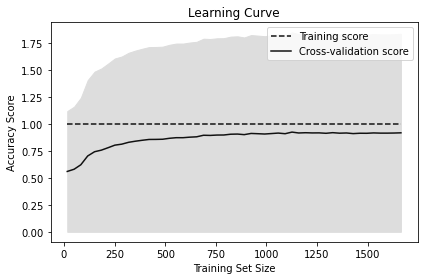

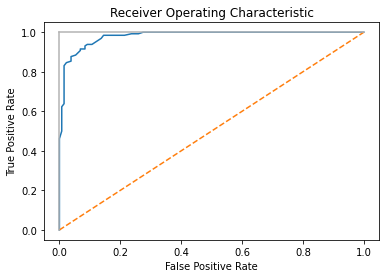

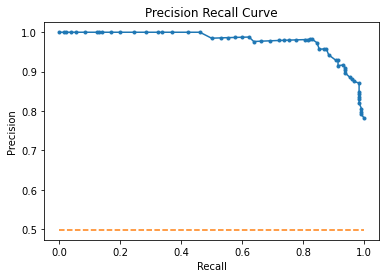

Best F1 score: 0.9236641221374045 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.923372,0.916667,0.930769,0.923664,0.927914,0.980417,0.9793


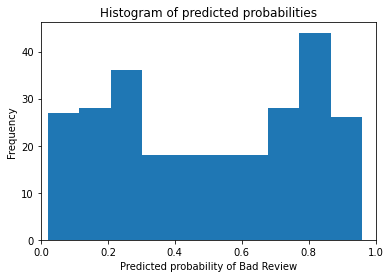

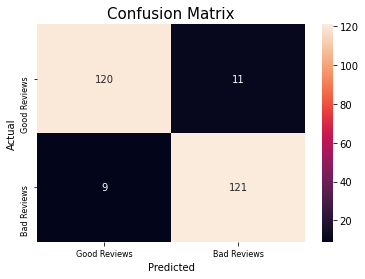

In [400]:
run_mod(rf,X_train_fp,y_train,X_val_fp,y_val)
rf_results1 = run_mod.results
rf_results1

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       131
           1       0.90      0.94      0.92       130

    accuracy                           0.92       261
   macro avg       0.92      0.92      0.92       261
weighted avg       0.92      0.92      0.92       261



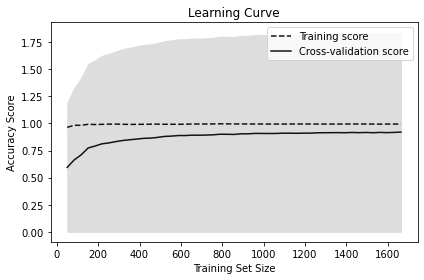

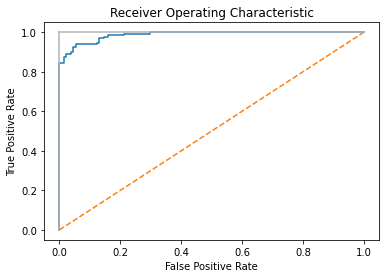

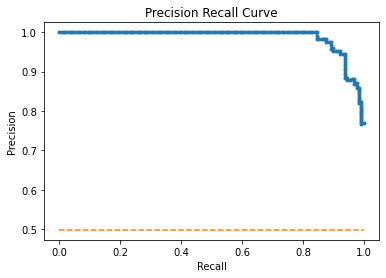

Best F1 score: 0.9172932330827067 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.915709,0.897059,0.938462,0.917293,0.929878,0.986788,0.987889


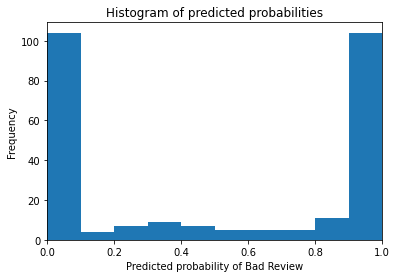

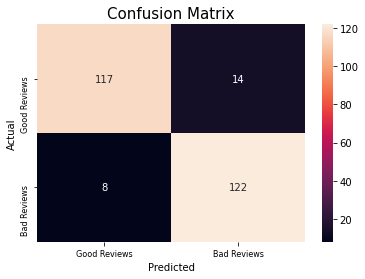

In [401]:
run_mod(svm,X_train_fp,y_train,X_val_fp,y_val)
svm_results1 = run_mod.results
svm_results1

## Feature Presence Bigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       131
           1       0.96      0.98      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



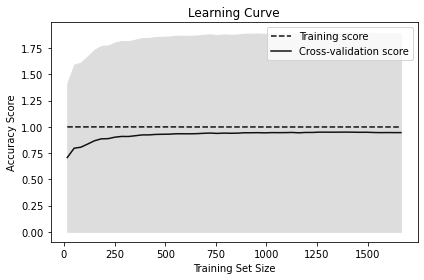

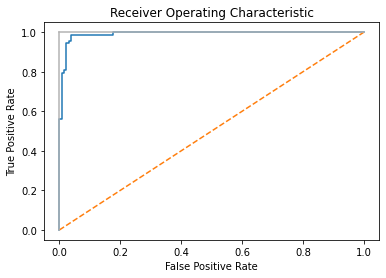

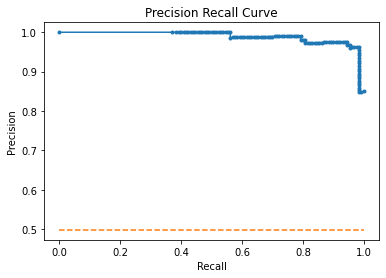

Best F1 score: 0.9696969696969696 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.969349,0.955224,0.984615,0.969697,0.978593,0.990722,0.989791


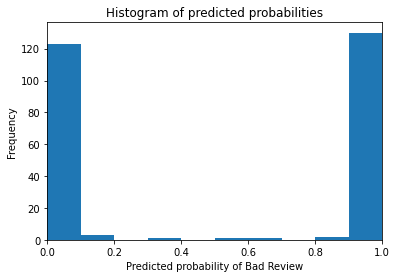

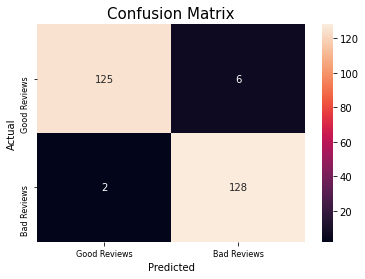

In [402]:
run_mod(nb,X_train_fp_big,y_train,X_val_fp_big,y_val)
nb_results2 = run_mod.results
nb_results2

### Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       131
           1       0.95      0.94      0.95       130

    accuracy                           0.95       261
   macro avg       0.95      0.95      0.95       261
weighted avg       0.95      0.95      0.95       261



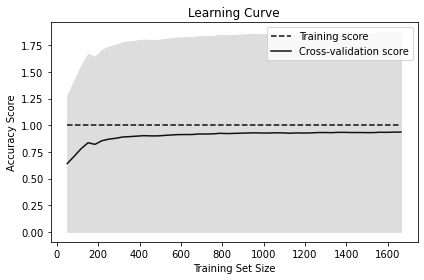

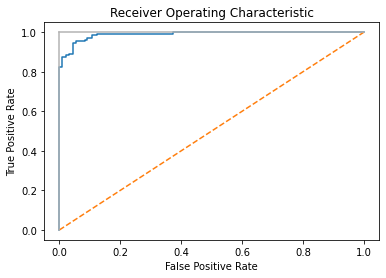

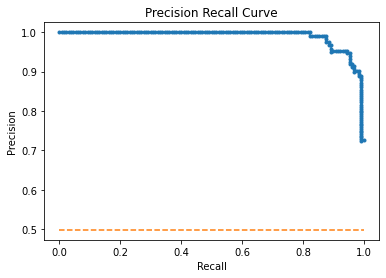

Best F1 score: 0.9457364341085271 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.94636,0.953125,0.938462,0.945736,0.941358,0.989489,0.990289


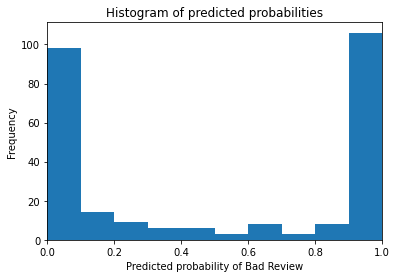

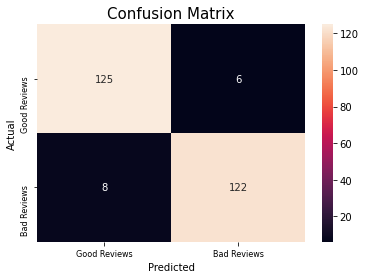

In [403]:
run_mod(lr,X_train_fp_big,y_train,X_val_fp_big,y_val)
lr_results2 = run_mod.results
lr_results2

### Random Forest

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       131
           1       0.91      0.91      0.91       130

    accuracy                           0.91       261
   macro avg       0.91      0.91      0.91       261
weighted avg       0.91      0.91      0.91       261



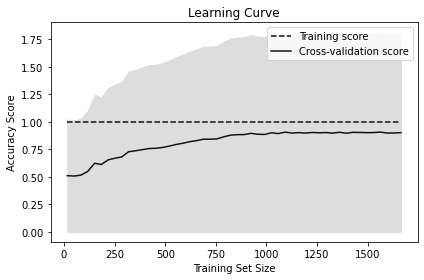

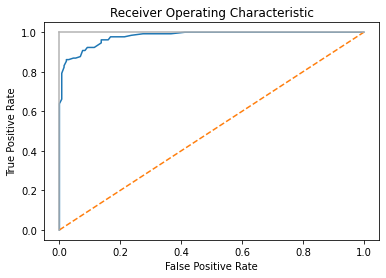

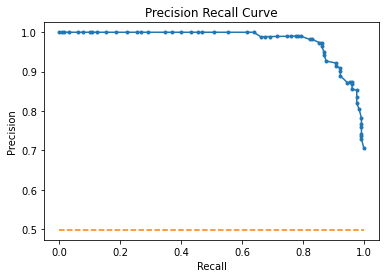

Best F1 score: 0.9111969111969112 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.911877,0.914729,0.907692,0.911197,0.909091,0.979243,0.98054


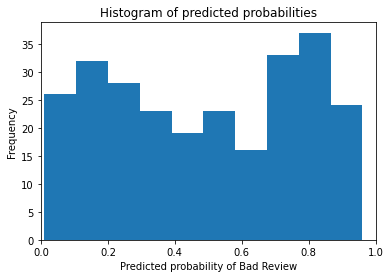

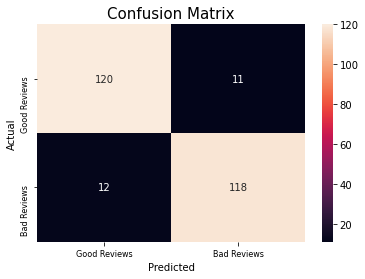

In [404]:
run_mod(rf,X_train_fp_big,y_train,X_val_fp_big,y_val)
rf_results2 = run_mod.results
rf_results2

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       131
           1       0.97      0.90      0.94       130

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261



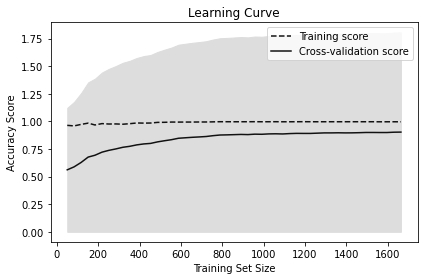

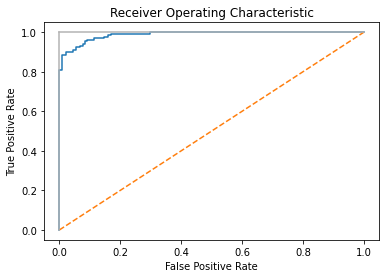

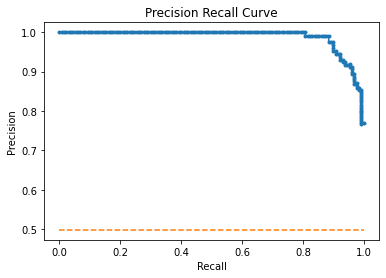

Best F1 score: 0.9359999999999999 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.938697,0.975,0.9,0.936,0.914063,0.987962,0.988813


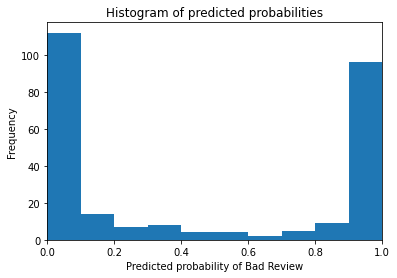

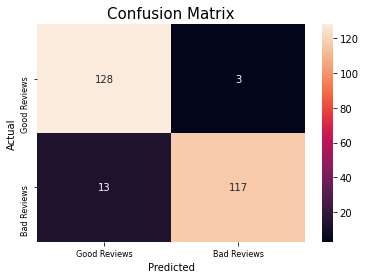

In [405]:
run_mod(svm,X_train_fp_big,y_train,X_val_fp_big,y_val)
svm_results2 = run_mod.results
svm_results2

## BOW

### Naive Bayes

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       131
           1       0.95      0.97      0.96       130

    accuracy                           0.96       261
   macro avg       0.96      0.96      0.96       261
weighted avg       0.96      0.96      0.96       261



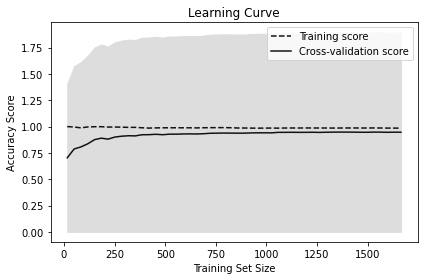

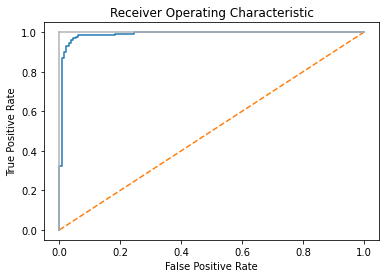

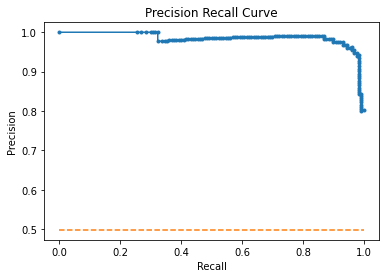

Best F1 score: 0.9618320610687022 Best threshold value: 0.1


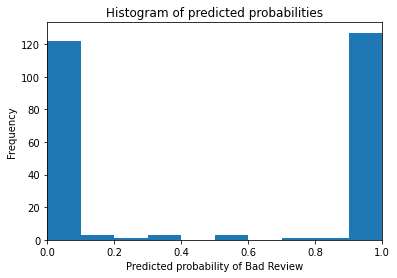

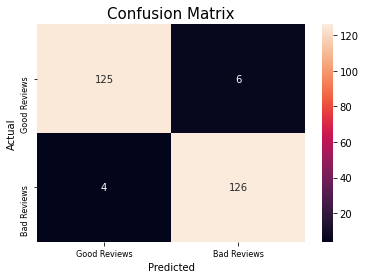

In [406]:
run_mod(nb,X_train_bow,y_train,X_val_bow,y_val)

In [407]:
nb_results3 = run_mod.results
nb_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961686,0.954545,0.969231,0.961832,0.966258,0.989078,0.986189


### Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       131
           1       0.95      0.94      0.95       130

    accuracy                           0.95       261
   macro avg       0.95      0.95      0.95       261
weighted avg       0.95      0.95      0.95       261



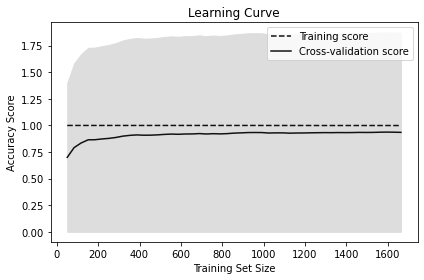

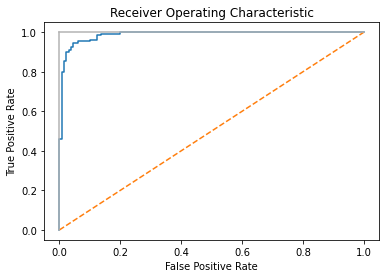

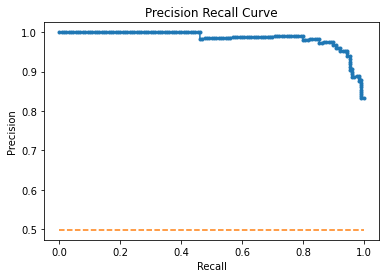

Best F1 score: 0.9457364341085271 Best threshold value: 0.1


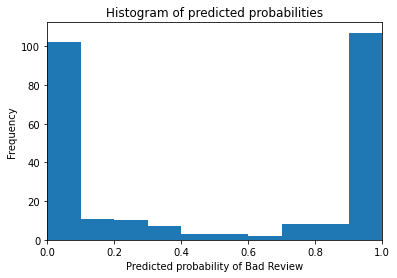

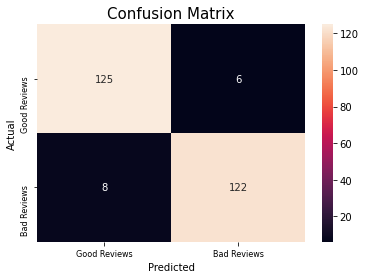

In [408]:
run_mod(lr,X_train_bow,y_train,X_val_bow,y_val)

In [409]:
lr_results3 = run_mod.results
lr_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.94636,0.953125,0.938462,0.945736,0.941358,0.987023,0.985677


### Random Forest

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       131
           1       0.93      0.93      0.93       130

    accuracy                           0.93       261
   macro avg       0.93      0.93      0.93       261
weighted avg       0.93      0.93      0.93       261



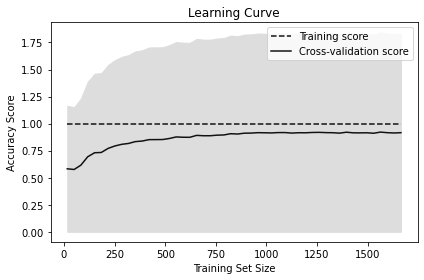

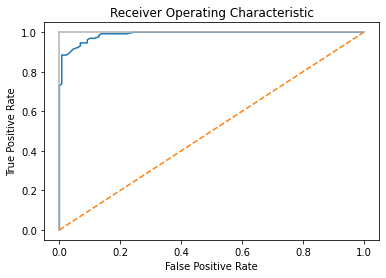

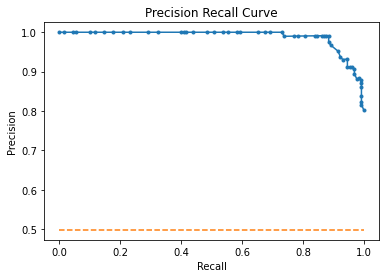

Best F1 score: 0.9307692307692308 Best threshold value: 0.1


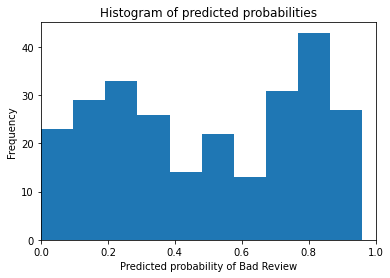

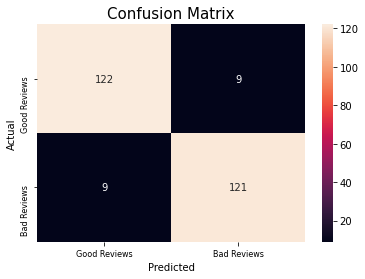

In [410]:
run_mod(rf,X_train_bow,y_train,X_val_bow,y_val)

In [411]:
rf_results3 = run_mod.results
rf_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.931034,0.930769,0.930769,0.930769,0.930769,0.988902,0.989221


### SVM

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       131
           1       0.92      0.95      0.93       130

    accuracy                           0.93       261
   macro avg       0.93      0.93      0.93       261
weighted avg       0.93      0.93      0.93       261



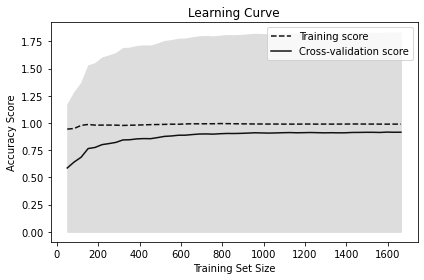

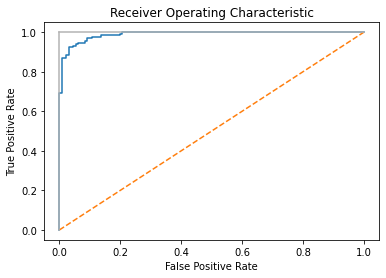

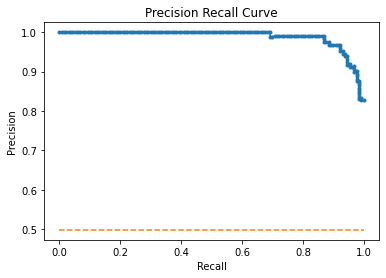

Best F1 score: 0.9318181818181818 Best threshold value: 0.1


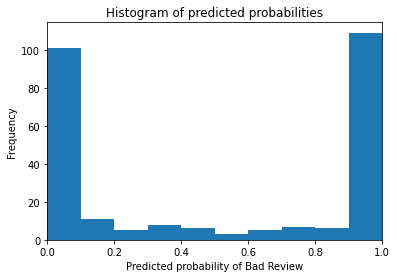

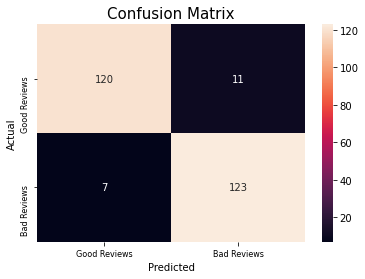

In [412]:
run_mod(svm,X_train_bow,y_train,X_val_bow,y_val)

In [413]:
svm_results3 = run_mod.results
svm_results3

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.931034,0.91791,0.946154,0.931818,0.940367,0.988843,0.989034


## NGRAMs

### Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       131
           1       0.95      0.98      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



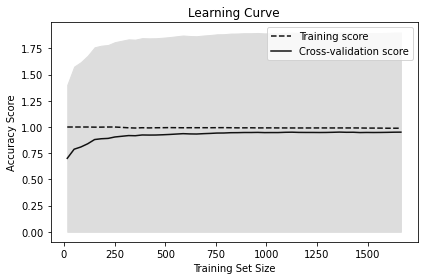

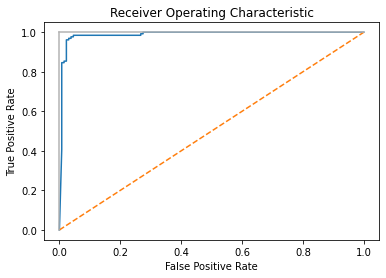

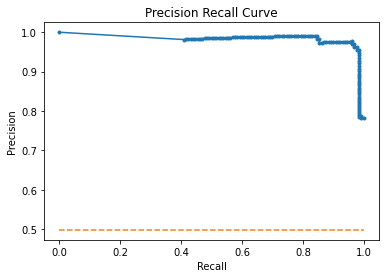

Best F1 score: 0.9657794676806083 Best threshold value: 0.1


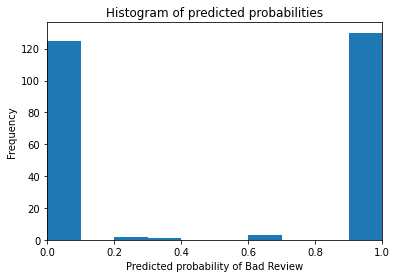

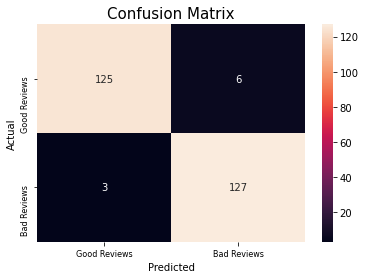

In [414]:
run_mod(nb,X_train_ngram,y_train,X_val_ngram,y_val)

In [415]:
nb_results4 = run_mod.results
nb_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.965517,0.954887,0.976923,0.965779,0.972435,0.987463,0.983677


### Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       131
           1       0.95      0.94      0.94       130

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261



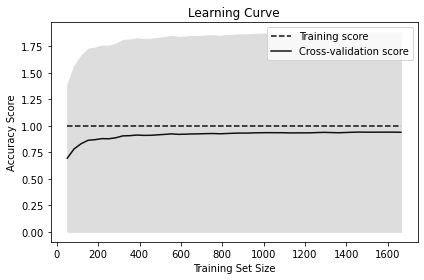

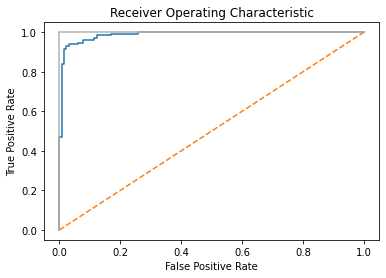

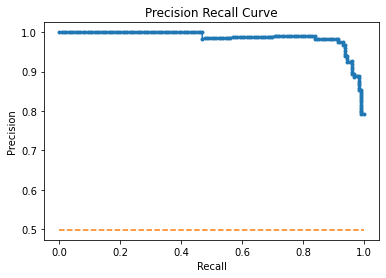

Best F1 score: 0.942084942084942 Best threshold value: 0.1


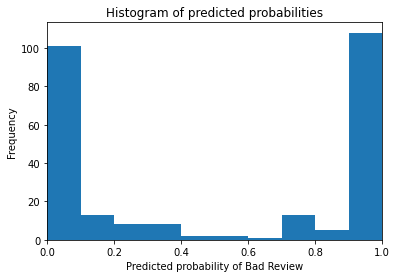

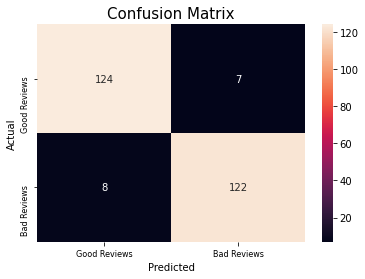

In [416]:
run_mod(lr,X_train_ngram,y_train,X_val_ngram,y_val)

In [417]:
lr_results4 = run_mod.results
lr_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.942529,0.945736,0.938462,0.942085,0.939908,0.987728,0.986756


### Random Forest

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       131
           1       0.92      0.95      0.94       130

    accuracy                           0.93       261
   macro avg       0.94      0.93      0.93       261
weighted avg       0.94      0.93      0.93       261



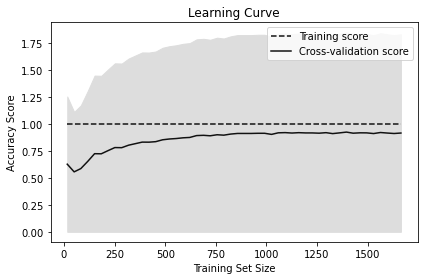

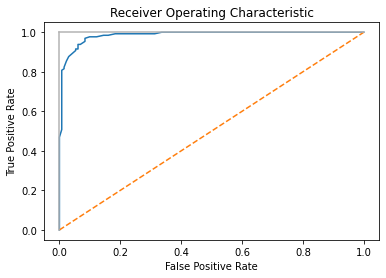

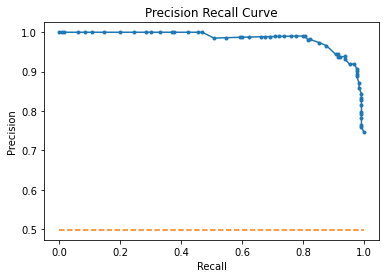

Best F1 score: 0.9358490566037735 Best threshold value: 0.1


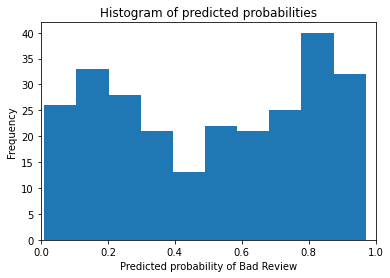

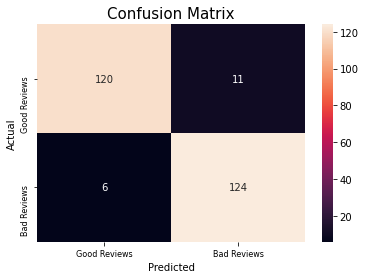

In [418]:
run_mod(rf,X_train_ngram,y_train,X_val_ngram,y_val)

In [419]:
rf_results4 = run_mod.results
rf_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.934866,0.918519,0.953846,0.935849,0.946565,0.985026,0.984264


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       131
           1       0.94      0.94      0.94       130

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261



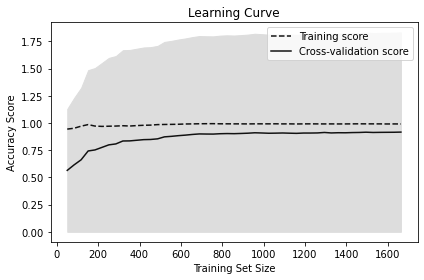

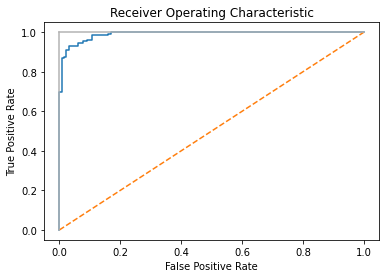

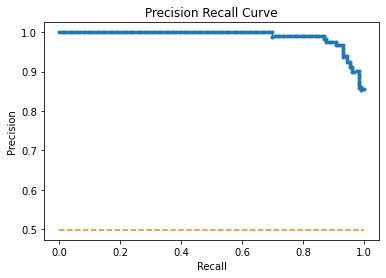

Best F1 score: 0.9384615384615385 Best threshold value: 0.1


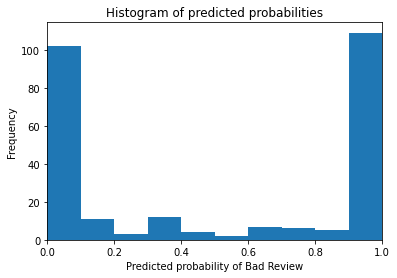

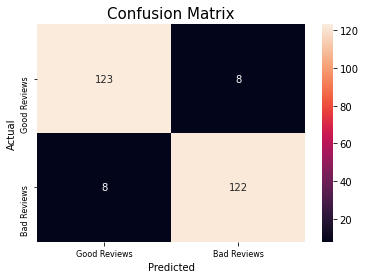

In [420]:
run_mod(svm,X_train_ngram,y_train,X_val_ngram,y_val)

In [421]:
svm_results4 = run_mod.results
svm_results4

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.938697,0.938462,0.938462,0.938462,0.938462,0.989959,0.989998


## TFIDF Unigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       131
           1       0.95      0.97      0.96       130

    accuracy                           0.96       261
   macro avg       0.96      0.96      0.96       261
weighted avg       0.96      0.96      0.96       261



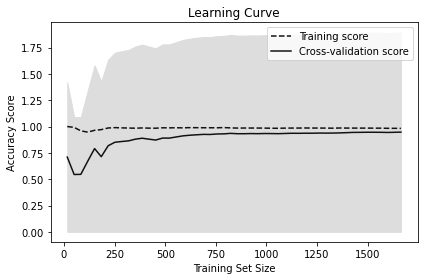

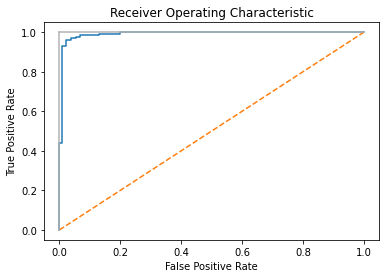

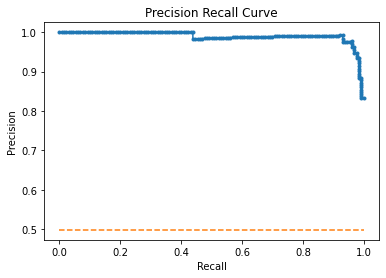

Best F1 score: 0.9618320610687022 Best threshold value: 0.1


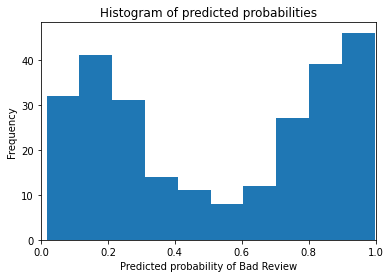

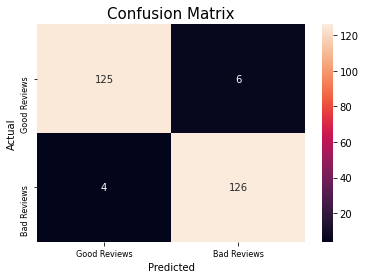

In [422]:
run_mod(nb,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [423]:
nb_results5 = run_mod.results
nb_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.961686,0.954545,0.969231,0.961832,0.966258,0.991779,0.990157


### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       131
           1       0.95      0.98      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



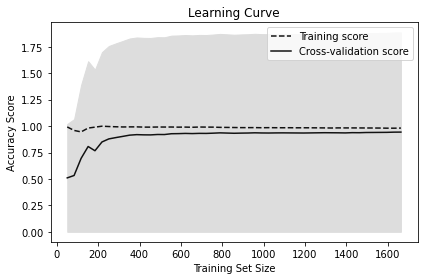

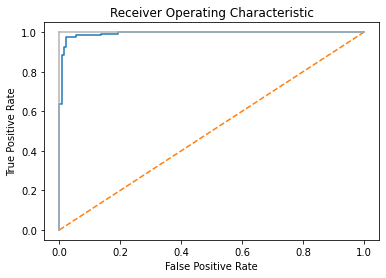

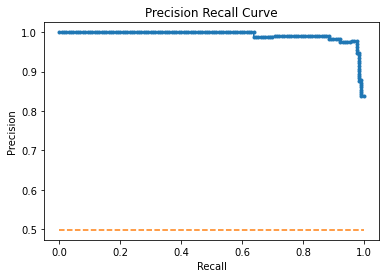

Best F1 score: 0.9657794676806083 Best threshold value: 0.1


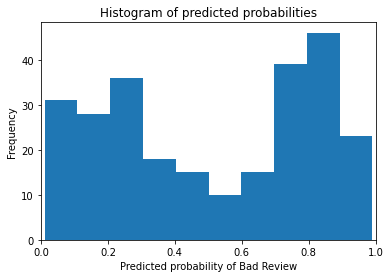

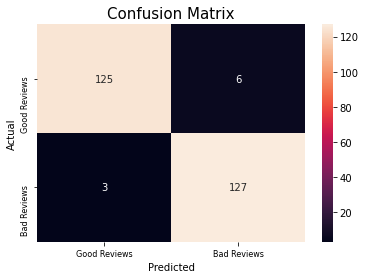

In [424]:
run_mod(lr,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [425]:
lr_results5 = run_mod.results
lr_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006


### Random Forest

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       131
           1       0.93      0.93      0.93       130

    accuracy                           0.93       261
   macro avg       0.93      0.93      0.93       261
weighted avg       0.93      0.93      0.93       261



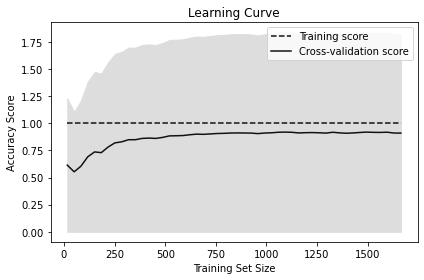

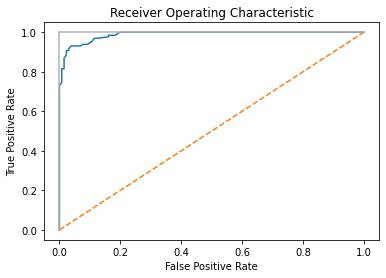

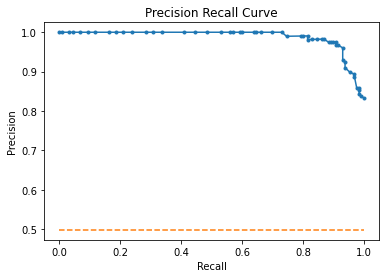

Best F1 score: 0.9307692307692308 Best threshold value: 0.1


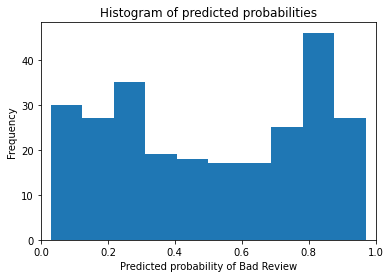

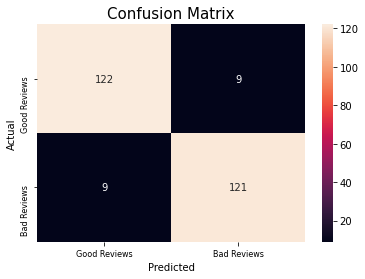

In [426]:
run_mod(rf,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [427]:
rf_results5 = run_mod.results
rf_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.931034,0.930769,0.930769,0.930769,0.930769,0.987962,0.988374


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       131
           1       0.96      0.97      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



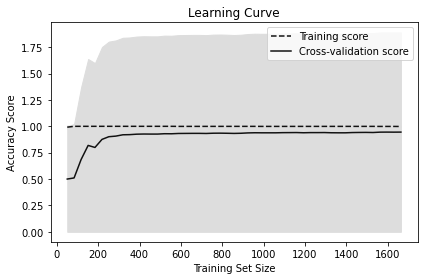

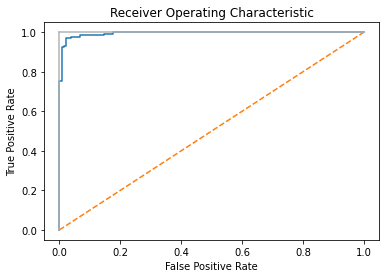

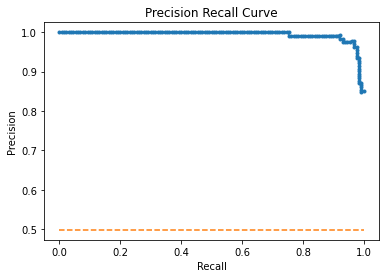

Best F1 score: 0.9655172413793103 Best threshold value: 0.1


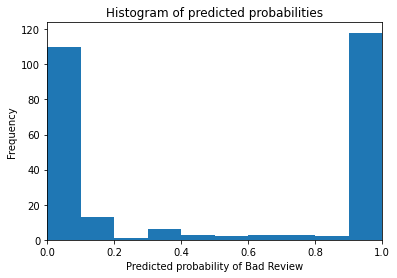

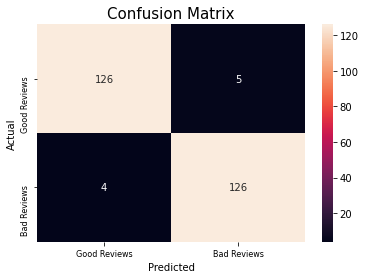

In [428]:
run_mod(svm,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [429]:
svm_results5 = run_mod.results
svm_results5

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.965517,0.961832,0.969231,0.965517,0.967742,0.994422,0.994468


## TFIDF Bigrams

###  Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       131
           1       0.96      0.98      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



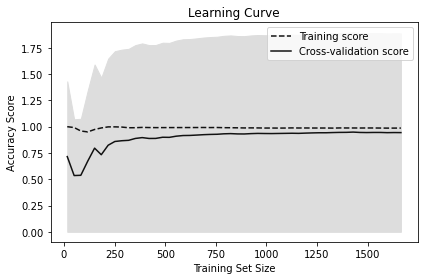

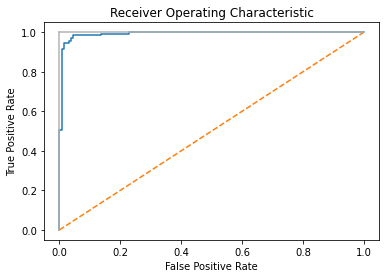

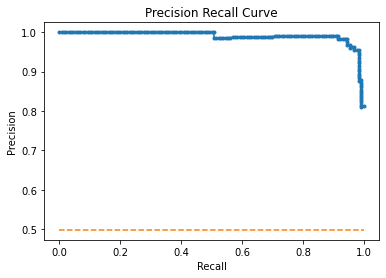

Best F1 score: 0.9696969696969696 Best threshold value: 0.1


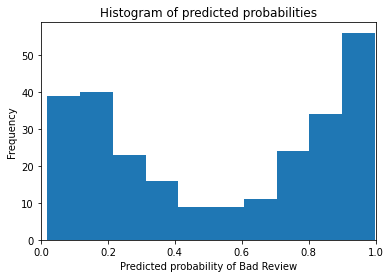

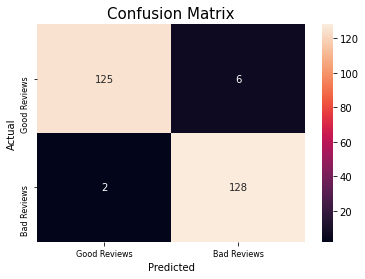

In [430]:
run_mod(nb,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [431]:
nb_results6 = run_mod.results
nb_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097


### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       131
           1       0.96      0.97      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



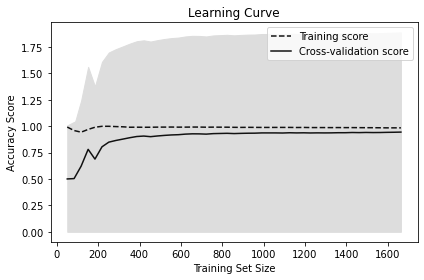

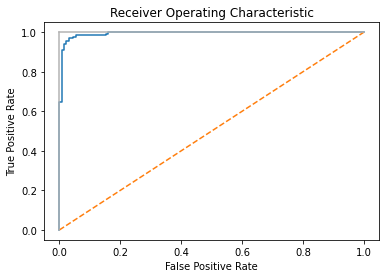

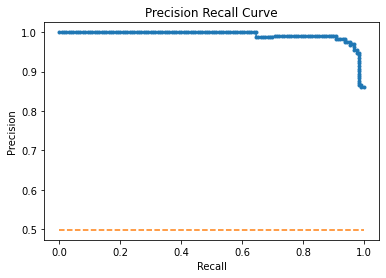

Best F1 score: 0.9655172413793103 Best threshold value: 0.1


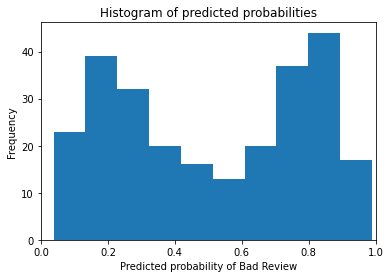

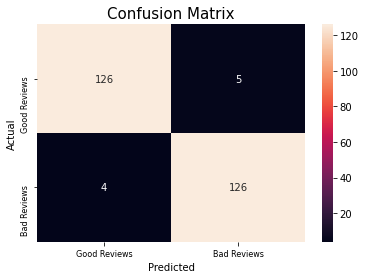

In [432]:
run_mod(lr,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [433]:
lr_results6 = run_mod.results
lr_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.965517,0.961832,0.969231,0.965517,0.967742,0.993541,0.993206


### Random Forest

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       131
           1       0.91      0.92      0.92       130

    accuracy                           0.92       261
   macro avg       0.92      0.92      0.92       261
weighted avg       0.92      0.92      0.92       261



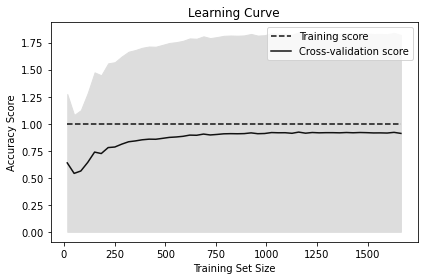

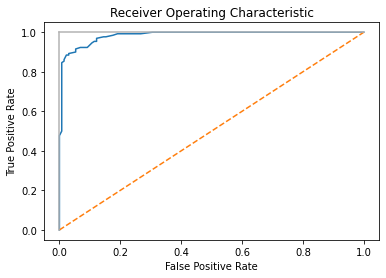

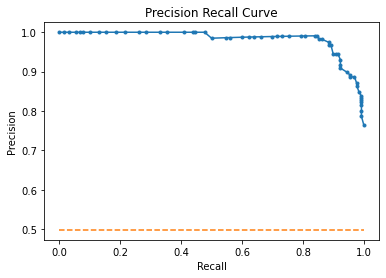

Best F1 score: 0.9160305343511451 Best threshold value: 0.1


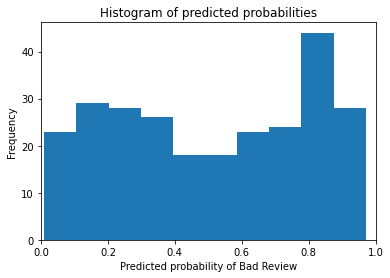

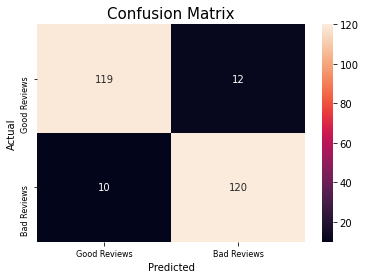

In [434]:
run_mod(rf,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [435]:
rf_results6 = run_mod.results
rf_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.915709,0.909091,0.923077,0.916031,0.920245,0.983852,0.983383


### SVM

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       131
           1       0.96      0.98      0.97       130

    accuracy                           0.97       261
   macro avg       0.97      0.97      0.97       261
weighted avg       0.97      0.97      0.97       261



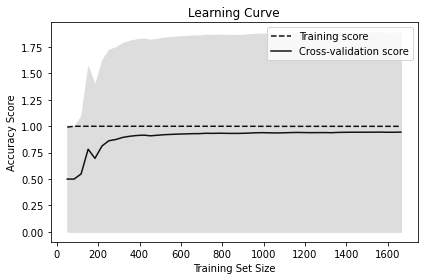

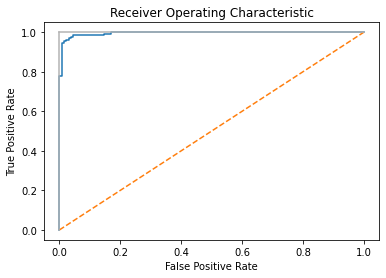

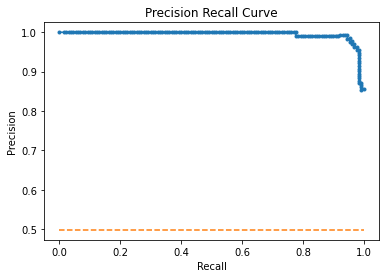

Best F1 score: 0.9694656488549619 Best threshold value: 0.1


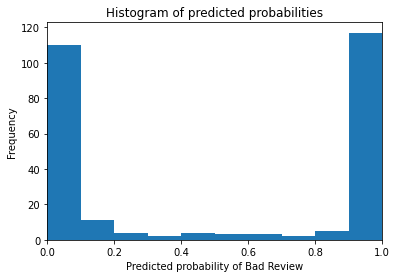

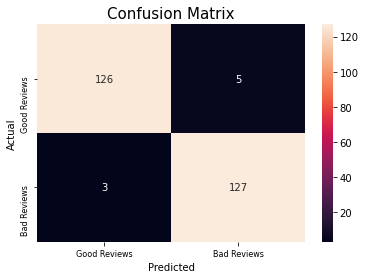

In [436]:
run_mod(svm,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [437]:
svm_results6 = run_mod.results
svm_results6

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.99521


# Section 10: Summarised Results Tables

### Feature Presence

In [438]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp = pd.concat([nb_results1,lr_results1,rf_results1,svm_results1])
model_summary_fp.set_index([models],inplace = True)
model_summary_fp
model_summary_fp.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Logistic Regression,0.938697,0.945312,0.930769,0.937984,0.933642,0.988550,0.989092
Multinomial NB,0.954023,0.940299,0.969231,0.954545,0.963303,0.987375,0.985619
Support Vector Machine,0.915709,0.897059,0.938462,0.917293,0.929878,0.986788,0.987889
Random Forest,0.923372,0.916667,0.930769,0.923664,0.927914,0.980417,0.979300


### Feature Presence Ngram

In [439]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp_ngram = pd.concat([nb_results2,lr_results2,rf_results2,svm_results2])
model_summary_fp_ngram.set_index([models],inplace = True)
model_summary_fp_ngram
model_summary_fp_ngram.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.969349,0.955224,0.984615,0.969697,0.978593,0.990722,0.989791
Logistic Regression,0.946360,0.953125,0.938462,0.945736,0.941358,0.989489,0.990289
Support Vector Machine,0.938697,0.975000,0.900000,0.936000,0.914063,0.987962,0.988813
Random Forest,0.911877,0.914729,0.907692,0.911197,0.909091,0.979243,0.980540


### BOWs

In [440]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bow = pd.concat([nb_results3,lr_results3,rf_results3,svm_results3])
model_summary_bow.set_index([models],inplace = True)
model_summary_bow
model_summary_bow.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.961686,0.954545,0.969231,0.961832,0.966258,0.989078,0.986189
Random Forest,0.931034,0.930769,0.930769,0.930769,0.930769,0.988902,0.989221
Support Vector Machine,0.931034,0.917910,0.946154,0.931818,0.940367,0.988843,0.989034
Logistic Regression,0.946360,0.953125,0.938462,0.945736,0.941358,0.987023,0.985677


In [441]:
# Save to csv
#model_summary_bow.to_csv("model_summary_bow.csv")

### BOW Ngram

In [442]:
model_summary_bow_ngram = pd.concat([nb_results4,lr_results4,rf_results4,svm_results4])
model_summary_bow_ngram.set_index([models],inplace = True)
model_summary_bow_ngram.sort_values(by = "ROCAUC",ascending = False)
model_summary_bow_ngram

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.965517,0.954887,0.976923,0.965779,0.972435,0.987463,0.983677
Logistic Regression,0.942529,0.945736,0.938462,0.942085,0.939908,0.987728,0.986756
Random Forest,0.934866,0.918519,0.953846,0.935849,0.946565,0.985026,0.984264
Support Vector Machine,0.938697,0.938462,0.938462,0.938462,0.938462,0.989959,0.989998


In [443]:
# Save to csv
#model_summary_ngram.to_csv("model_summary_ngram.csv")

### TFIDF 

In [444]:
model_summary_tfidf1 = pd.concat([nb_results5,lr_results5,rf_results5,svm_results5])
model_summary_tfidf1.set_index([models],inplace = True)
model_summary_tfidf1.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf1

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.961686,0.954545,0.969231,0.961832,0.966258,0.991779,0.990157
Logistic Regression,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006
Random Forest,0.931034,0.930769,0.930769,0.930769,0.930769,0.987962,0.988374
Support Vector Machine,0.965517,0.961832,0.969231,0.965517,0.967742,0.994422,0.994468


In [445]:
# Save to csv
#model_summary_tfidf1.to_csv("model_summary_tfidf_bow.csv")

### TFIDF Ngram

In [446]:
model_summary_tfidf2 = pd.concat([nb_results6,lr_results6,rf_results6,svm_results6])
model_summary_tfidf2.set_index([models],inplace = True)
model_summary_tfidf2.sort_values(by = "ROCAUC",ascending = False)
model_summary_tfidf2

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097
Logistic Regression,0.965517,0.961832,0.969231,0.965517,0.967742,0.993541,0.993206
Random Forest,0.915709,0.909091,0.923077,0.916031,0.920245,0.983852,0.983383
Support Vector Machine,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.995210


### Summary of all models

In [447]:
all_ml_models = pd.concat([model_summary_fp,model_summary_fp_ngram,model_summary_bow,model_summary_ngram,model_summary_tfidf1,model_summary_tfidf2])
all_ml_models.index = ['Multinomial NB FP', 'Logistic Regression FP', 'Random Forest FP','Support Vector Machine FP',
                       'Multinomial NB FP BIG', 'Logistic Regression FP BIG', 'Random Forest FP BIG','Support Vector Machine FP BIG',
                       'Multinomial NB BOW', 'Logistic Regression BOW', 'Random Forest BOW',
                       'Support Vector Machine BOW','Multinomial NB BIG', 'Logistic Regression BIG', 'Random Forest BIG',
                       'Support Vector Machine BIG','Multinomial NB TFIDF', 'Logistic Regression TFIDF', 'Random Forest TFIDF',
                       'Support Vector Machine TFIDF','Multinomial NB TFIDF BIG', 'Logistic Regression TFIDF BIG', 'Random Forest TFIDF BIG',
                       'Support Vector Machine TFIDF BIG']

In [448]:
# Sorted by Accuracy
all_ml_models.sort_values(by = "Accuracy",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Support Vector Machine TFIDF BIG,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.995210
Multinomial NB TFIDF BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097
Multinomial NB FP BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.990722,0.989791
Logistic Regression TFIDF,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006
Logistic Regression TFIDF BIG,0.965517,0.961832,0.969231,0.965517,0.967742,0.993541,0.993206


In [449]:
# Sorted by ROCAUC
all_ml_models.sort_values(by = "ROCAUC",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Support Vector Machine TFIDF BIG,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.995210
Support Vector Machine TFIDF,0.965517,0.961832,0.969231,0.965517,0.967742,0.994422,0.994468
Logistic Regression TFIDF BIG,0.965517,0.961832,0.969231,0.965517,0.967742,0.993541,0.993206
Logistic Regression TFIDF,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006
Multinomial NB TFIDF BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097


In [450]:
# Sorted by recall
all_ml_models.sort_values(by = "Recall",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB FP BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.990722,0.989791
Multinomial NB TFIDF BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097
Multinomial NB BIG,0.965517,0.954887,0.976923,0.965779,0.972435,0.987463,0.983677
Logistic Regression TFIDF,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006
Support Vector Machine TFIDF BIG,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.995210


In [451]:
# Sorted by F1-score
all_ml_models.sort_values(by = "F1",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB FP BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.990722,0.989791
Multinomial NB TFIDF BIG,0.969349,0.955224,0.984615,0.969697,0.978593,0.992073,0.991097
Support Vector Machine TFIDF BIG,0.969349,0.962121,0.976923,0.969466,0.973926,0.995126,0.995210
Logistic Regression TFIDF,0.965517,0.954887,0.976923,0.965779,0.972435,0.993365,0.993006
Multinomial NB BIG,0.965517,0.954887,0.976923,0.965779,0.972435,0.987463,0.983677


In [452]:
final_text_models = all_ml_models.sort_values(by = "ROCAUC",ascending = False)
final_text_models.to_csv("TextSentimentModels.csv")

Recall is highest for the Multinomial NB model and accuracy matches the top SVM model.

# Section 11: Hyperparameter Tuning

In [453]:
best_model = MultinomialNB()
best_model.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

## Alpha

In [473]:
# [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000].
param_range = np.arange(0.001,500,10)
train_scoreNum, test_scoreNum = validation_curve(
                                MultinomialNB(),
                                X = X_train_fp_big, y = y_train, 
                                param_name = 'alpha', 
                                param_range = param_range, cv = 3)

In [476]:
# Run various alpha values and plot training and test scores
def valid(train_scoreNum,test_scoreNum):
    
    train_mean = np.mean(train_scoreNum,axis = 1)
    train_std = np.std(train_scoreNum,axis = 1)
    test_mean = np.mean(test_scoreNum,axis = 1)
    test_std = np.std(test_scoreNum,axis = 1)
    
    plt.plot(param_range,train_mean, label = "Training Score", color = "black")
    plt.plot(param_range, test_mean, label = "Test Score", color = "dimgray")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color = "gainsboro")

    plt.title("Multinomial Naive Bayes Validation Curve")
    plt.xlabel("Parameter Number")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc = "best")
    plt.show()

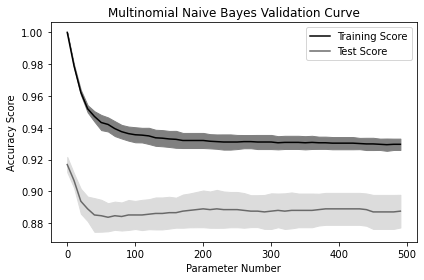

In [477]:
valid(train_scoreNum,test_scoreNum)

Varying alpha does not increase accuracy score

# Section 12: Grid SearchCV

### Accuracy Metric - varying parameters

In [485]:
parameters = {'alpha':(0.01,0.1,1.0),'fit_prior':[True,False],'class_prior' : [None, [.1,.9],[.2, .8],[.3,.7],[.4,.6],[.5,.5]]}
nb = MultinomialNB()
clf = GridSearchCV(nb,param_grid=parameters, cv = 10, scoring = 'accuracy')
clf.fit(X_train_fp_big,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': (0.01, 0.1, 1.0),
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [495]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'alpha': 1.0, 'class_prior': [0.1, 0.9], 'fit_prior': True}
Best score: 0.9514584100110417
Best estimator: MultinomialNB(class_prior=[0.1, 0.9])




### Recall

In [496]:
clf2 = GridSearchCV(nb,param_grid=parameters, cv = 10, scoring = 'recall')
clf2.fit(X_train_fp_big,y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': (0.01, 0.1, 1.0),
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='recall')

In [497]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf2)

Best parameters are: {'alpha': 1.0, 'class_prior': [0.1, 0.9], 'fit_prior': True}
Best score: 0.9413919413919414
Best estimator: MultinomialNB(class_prior=[0.1, 0.9])




### Best Model with Validation Set

In [500]:
# Set up the best model
best_model = MultinomialNB(alpha = 1,fit_prior = True, class_prior = [0.1,0.9])
best_model.fit(X_train_fp_big,y_train)

MultinomialNB(alpha=1, class_prior=[0.1, 0.9])

In [501]:
print("Validation Set Accuracy:",best_model.score(X_val_fp_big,y_val))

Validation Set Accuracy: 0.9540229885057471


In [504]:
y_pred_best =  best_model.predict(X_val_fp_big)

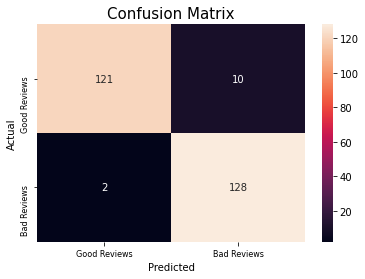

In [505]:
# Confusion Matrix
fig, ax = plt.subplots()
cf_matrix = confusion_matrix(y_val, y_pred_best)
sns.heatmap(cf_matrix, annot = True, fmt = "d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix", fontsize = 15)
_ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
_ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)